### Import lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

### Import phishing_site_urls dataset

In [2]:
urls_df = pd.read_csv(r'phishing_site_urls.csv')

urls_df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [3]:
urls_df.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [4]:
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [5]:
urls_df.isnull().sum()

URL      0
Label    0
dtype: int64

In [6]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [7]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

good    392924
bad     156422
Name: Label, dtype: int64


### Preprocessing

In [8]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
urls_df.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [9]:
tokenizer.tokenize(urls_df.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [10]:
urls_df['text_tokenized'] = urls_df.URL.map(lambda t: tokenizer.tokenize(t))

In [11]:
urls_df.sample(5)

,URL,Label,text_tokenized
129275,acofficebsb.com.br/wp-admin/js,bad,"[acofficebsb, com, br, wp, admin, js]"
183090,encyclopedia2.thefreedictionary.com/Canadian+a...,good,"[encyclopedia, thefreedictionary, com, Canadia..."
489571,boschservisi.info.tr/wp-content/themes/twentyt...,bad,"[boschservisi, info, tr, wp, content, themes, ..."
148695,benfinkshapiro.tumblr.com/,good,"[benfinkshapiro, tumblr, com]"
28363,maxkz.com/fb6ce75ab9e3907e6ad458f002066df7/log...,bad,"[maxkz, com, fb, ce, ab, e, e, ad, f, df, logi..."


In [12]:
stemmer = SnowballStemmer("english")
urls_df['text_stemmed'] = urls_df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])


In [13]:
urls_df.sample(5)

,URL,Label,text_tokenized,text_stemmed
323766,everten.com.au/Robert-Gordon-Baking-Cups.html,good,"[everten, com, au, Robert, Gordon, Baking, Cup...","[everten, com, au, robert, gordon, bake, cup, ..."
522389,6i3cb6owitcouepv.micropaysearch.com/img/flags/...,bad,"[i, cb, owitcouepv, micropaysearch, com, img, ...","[i, cb, owitcouepv, micropaysearch, com, img, ..."
369834,lake-link.com/lakes/lake.cfm?LakeID=18595,good,"[lake, link, com, lakes, lake, cfm, LakeID]","[lake, link, com, lake, lake, cfm, lakeid]"
431793,skiracing.com/?q=node/9187,good,"[skiracing, com, q, node]","[skirac, com, q, node]"
322027,eng.hctx.net/,good,"[eng, hctx, net]","[eng, hctx, net]"


In [14]:
urls_df['text_sent'] = urls_df['text_stemmed'].map(lambda l: ' '.join(l))

In [15]:
urls_df.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
325045,exchange-rates.org/history.aspx?iso_code=VEF&b...,good,"[exchange, rates, org, history, aspx, iso, cod...","[exchang, rate, org, histori, aspx, iso, code,...",exchang rate org histori aspx iso code vef bas...
252073,uboat.net/allies/warships/ship/228.html,good,"[uboat, net, allies, warships, ship, html]","[uboat, net, alli, warship, ship, html]",uboat net alli warship ship html
167821,ebookdownloadhub.blogspot.com/,good,"[ebookdownloadhub, blogspot, com]","[ebookdownloadhub, blogspot, com]",ebookdownloadhub blogspot com
442005,tcm.com/tcmdb/person/41424%7C22133/Bing-Crosby/,good,"[tcm, com, tcmdb, person, C, Bing, Crosby]","[tcm, com, tcmdb, person, c, bing, crosbi]",tcm com tcmdb person c bing crosbi
114356,ijah.in/-/?sid=abuse@hotmail.com,bad,"[ijah, in, sid, abuse, hotmail, com]","[ijah, in, sid, abus, hotmail, com]",ijah in sid abus hotmail com


### Visualization

In [16]:
bad_sites = urls_df[urls_df.Label == 'bad']
good_sites = urls_df[urls_df.Label == 'good']

In [17]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [18]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


### Creating Model

In [19]:
cv = CountVectorizer()
feature = cv.fit_transform(urls_df.text_sent)

In [20]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
trainX, testX, trainY, testY = train_test_split(feature, urls_df.Label)

### Logistic Regression

In [22]:
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9638917407544945

In [23]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9789203633901201
Testing Accuracy : 0.9638917407544945

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.93     36808
        Good       0.99      0.96      0.98    100529

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot: >

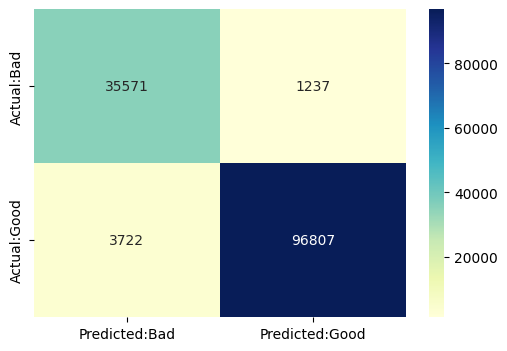

In [24]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Multinomial Naive Bayes

In [25]:
mnb = MultinomialNB()
mnb.fit(trainX,trainY)
mnb.score(testX,testY)

0.9574623007638146

In [26]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9742893965908511
Testing Accuracy : 0.9574623007638146

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.93      0.92     38471
        Good       0.97      0.97      0.97     98866

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot: >

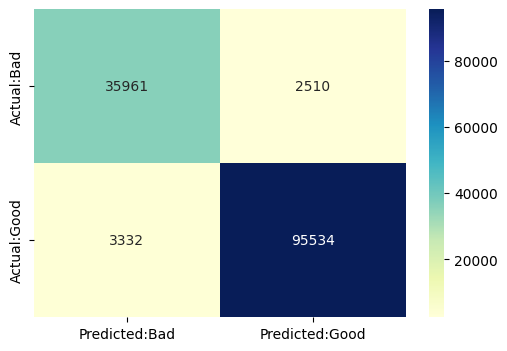

In [27]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Support Vector Machine

In [28]:
X_train, X_test, y_train, y_test = train_test_split(feature, urls_df.Label, test_size=0.25, random_state=27)


In [29]:
SVC_model = svm.SVC(kernel='linear')

In [30]:
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
SVC_prediction = SVC_model.predict(X_test)

In [32]:
print(confusion_matrix(SVC_prediction, y_test))

[[37192  1173]
 [ 1873 97099]]


### KNN_model

In [33]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

KNN_model.fit(X_train, y_train)

KNN_prediction = KNN_model.predict(X_test)
print(classification_report(KNN_prediction, y_test))

              precision    recall  f1-score   support

         bad       0.92      0.87      0.89     41730
        good       0.94      0.97      0.96     95607

    accuracy                           0.94    137337
   macro avg       0.93      0.92      0.93    137337
weighted avg       0.94      0.94      0.94    137337



Logistic Regression    0.96
MultinomialNB          0.96
Name: Accuracy, dtype: float64


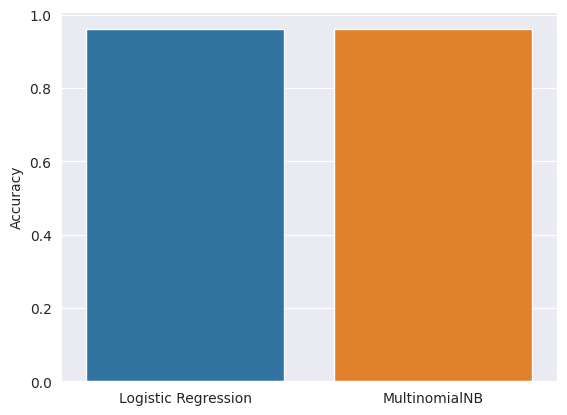

In [34]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(x=acc.index,y=acc.Accuracy)
print(acc.Accuracy)

### sklearn pipeline with Logistic Regression

In [35]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [36]:
trainX, testX, trainY, testY = train_test_split(urls_df.URL, urls_df.Label)

In [37]:
pipeline_ls.fit(trainX,trainY)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [38]:
pipeline_ls.score(testX,testY) 

0.9655154838098983

Training Accuracy : 0.9796048144579366
Testing Accuracy : 0.9655154838098983

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36595
        Good       0.99      0.96      0.98    100742

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<AxesSubplot: >

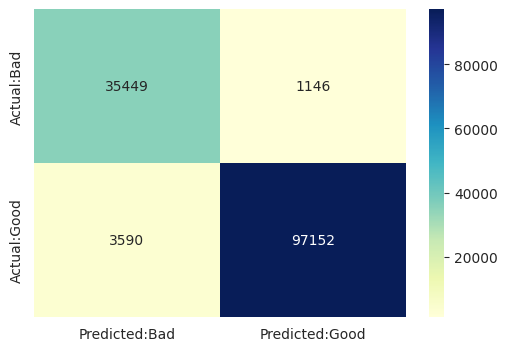

In [39]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [40]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9655154838098983


In [41]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
